# <b><span style='color:#F1A424'>|</span> Mutual Headed Attention <span style='color:#F1A424'>|</span></b>

## Building a Mutual Attention Model from Scratch with PyTorch

This notebook demonstrates how to build a mutual attention model for skin disease classification using both images and metadata. The work is inspired by the ISIC 2024 Kaggle competition, where the low resolution of images made it necessary to use metadata to extract meaningful information. This notebook includes the full code implementation of the model, which combines image and metadata features using a mutual attention mechanism.

For a detailed step-by-step guide, you can refer to the article here : https://medium.com/@mattducrest/building-a-mutual-attention-model-from-scratch-with-pytorch-7d0e07778032

If you'd like to download the dataset, you can find it here: https://www.kaggle.com/competitions/isic-2024-challenge/data

### How the Model Works

The model consists of three main components:

1. **Image Encoder**: A Vision Transformer (ViT) extracts features from images.
2. **Metadata Encoder**: A soft label encoder processes the metadata into features.
3. **Mutual Attention Decoder**: A mutual attention block integrates the features from the image and metadata encoders to make predictions.

The following sections provide a detailed breakdown of each component and the code used to implement them.

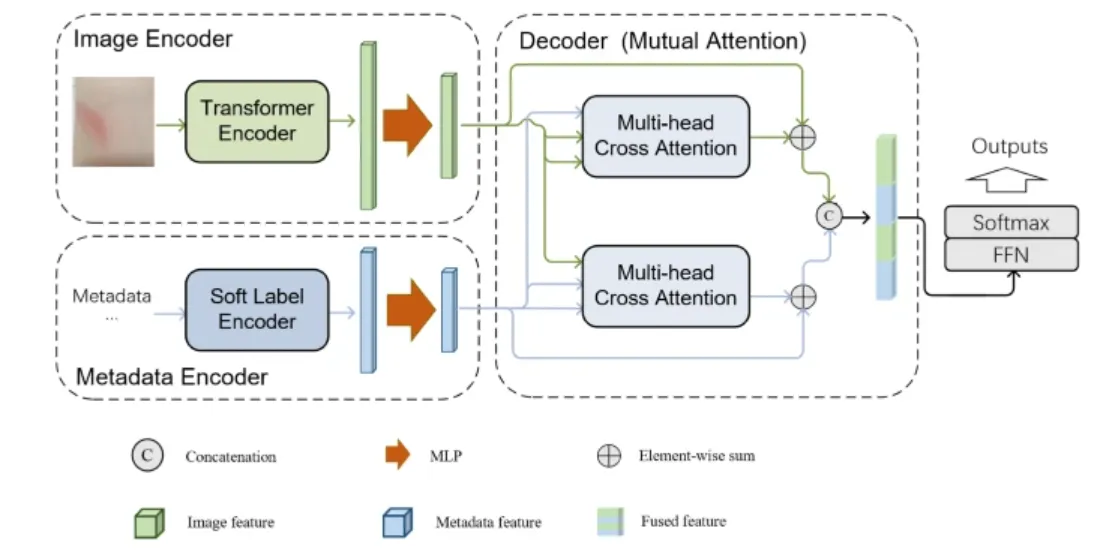

In [1]:
import os
import timm
import h5py
import numpy as np
import pandas as pd
import random as rd
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import OrdinalEncoder

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

from albumentations.pytorch import ToTensorV2
import albumentations as A

np.random.seed(42)
torch.manual_seed(42)

## Setting Up the Device

We will use GPU if it's available for faster computations. The device is set up as follows:

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Loading the Data

In this competition, we are provided with a dataset of 400,000 images and corresponding metadata. The metadata includes attributes such as age, sex, and lesion location. This section loads the metadata from a CSV file and prepares it for use in training. We also filter out irrelevant columns to keep only the necessary features.

In [3]:
train_metadata_path = 'isic-2024-challenge/train-metadata.csv'
train_image_path = 'isic-2024-challenge/train-image.hdf5'
isic_2024_metadata_df = pd.read_csv(train_metadata_path)

features_remove = ['lesion_id','attribution', 'copyright_license', 'image_type','iddx_full','iddx_1','iddx_2','iddx_3','iddx_4','iddx_5','mel_mitotic_index', 'mel_thick_mm','tbp_lv_dnn_lesion_confidence']

isic_2024_metadata_df.head()

/tmp/ipykernel_34/2296154151.py:3: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  isic_2024_metadata_df = pd.read_csv(train_metadata_path)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


## Data Loader Classes

To effectively handle image and metadata inputs, we define custom data loader classes:

1. **For HDF5 Files**: This loader handles images stored in HDF5 format, which is common for large datasets.
2. **For JPG and PNG Files**: This loader is used when images are stored as individual JPG or PNG files.

Both loaders will return a tuple of `(image, metadata, target)` for each sample.

In [4]:
class ImageLoaderWithMetadata(Dataset):
    def __init__(self, df, file_hdf, transform=None, subset_size=None, has_target=True):
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.transform = transform
        self.has_target = has_target
        self.isic_ids = df['isic_id'].tolist()
        
        if subset_size is not None and subset_size < len(df):
            self.df = df.sample(n=subset_size).reset_index(drop=True)
        else:
            self.df = df.reset_index(drop=True)
        
        if self.has_target:
            self.targets = self.df['target'].values
            self.metadata_cols = self.df.drop(columns=['target', 'isic_id']).columns
        else:
            self.metadata_cols = self.df.drop(columns=['isic_id']).columns

    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        image = Image.open(BytesIO(self.fp_hdf[isic_id][()]))
        
        if self.transform:
            image = np.array(image)
            transformed = self.transform(image=image)
            image = transformed['image']
            image = image / 255 
        
        metadata = self.df.loc[index, self.metadata_cols].values.astype(np.float32)
        
        if self.has_target:
            target = self.targets[index]
            return (image, metadata, target)
        else:
            return image, metadata

In [5]:
class ImageLoaderWithMetadata_jpgs(Dataset):
    def __init__(self, df, image_path, has_target=True, transform=None, subset_size=None):
        self.df = df
        self.transform = transform
        self.has_target = has_target
        self.isic_ids = df['isic_id'].tolist()
        
        self.img_path = os.path.join(image_path)
        
        if subset_size is not None and subset_size < len(df):
            self.df = df.sample(n=subset_size).reset_index(drop=True)
        else:
            self.df = df.reset_index(drop=True)
        
        if self.has_target:
            self.targets = self.df['target'].values
            self.metadata = self.df.drop(columns=['target', 'isic_id']).values  # Ensure isic_id is dropped
        else:
            self.metadata = self.df.drop(columns=['isic_id']).values  # Ensure isic_id is dropped

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img_path = os.path.join(self.img_path, isic_id + '.jpg')  
        image = Image.open(img_path)
        
        if self.transform:
            image = np.array(image)
            transformed = self.transform(image=image)  # Apply transformation
            image = transformed['image']
            image = image / 255 

        metadata = self.metadata[index]
        
        if self.has_target:
            target = self.targets[index]
            return (image, metadata, target)
        else:
            return image, metadata

## Data Augmentation

Data augmentation is essential for improving the robustness and generalization of our model. We use the `albumentations` library to perform various augmentation techniques such as resizing, flipping, brightness adjustment, and color shifting. These augmentations help simulate different real-world scenarios and make our model more resilient to variations in input data.

In [6]:
image_size = (224,224)

train_transform_no_augment = A.Compose([
    
    A.Resize(image_size[0], image_size[1]),  # Resize to the target size
    ToTensorV2(),  # Convert the image to a PyTorch tensor
])

train_transfrom_with_augment = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.01, rotate_limit=20, p=0.5),
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.7),   
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.5, p=0.8),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.8),  # Slight R, G and B shift
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.8),  # Slight changes to hue, saturation, and value (brightness)
    
    A.Resize(image_size[0], image_size[1]),
    ToTensorV2(),
])

## Soft Label Encoder

A soft label encoder is used to preprocess the metadata. Instead of using one-hot encoding, which results in many zero elements, we use soft label encoding. This method replaces zeros with small values (0.01) to ensure that more neurons in the fully connected network are activated during training. This approach provides richer information in the input layer.

Here’s the implementation of the soft label encoder function:

In [7]:
number_of_sample = 15_000

def soft_label_encoder(df):
    df = df.drop(columns = features_remove)
    non_numeric_columns = df.select_dtypes(exclude=['number']).columns
    non_numeric_columns = non_numeric_columns.drop('isic_id')

    category_encoder = OrdinalEncoder(
    categories='auto',                  # The encoder will automatically determine the categories for each feature.
    dtype=int,                          # ouput them as integers
    handle_unknown='use_encoded_value', # The encoder will use a specified integer value for these unknown categories.
    unknown_value=-2,                   # which is -2 for unknown values
    encoded_missing_value=-1,           # and -1 for encoded missing value
    )

    X_cat = category_encoder.fit_transform(df[non_numeric_columns])
    for c, cat_col in enumerate(non_numeric_columns):
        df[cat_col] = X_cat[:, c]

    df = df.replace([np.inf, -np.inf, 0], np.nan).fillna(0.01)
    df['target'] = df['target'].replace(0.01,0)

    rd.seed(42) # For reproducibility

    malignant_df = df[df['target']==1]
    benign_df = df[df['target']==0]
    total = range(len(benign_df))
    index = rd.sample(total,number_of_sample - len(malignant_df))
    benign_df_2 = benign_df.iloc[index].reset_index(drop=True)

    df = pd.concat([malignant_df,benign_df_2]).reset_index(drop=True)
        
    shuffled_df = df.sample(frac=1, random_state = 42).reset_index(drop=True) 
    
    return shuffled_df

## Creating DataLoader from the HDF5 File

In [8]:
class ConcatDatasetWithMetadataAndTarget(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets) 
        self.targets = np.concatenate([dataset.targets for dataset in datasets])
    
    def __getitem__(self, idx):
        image, metadata, target = super().__getitem__(idx)
        
        target = self.targets[idx]
        return image, metadata, target

In [9]:
soft_shuffled_df = soft_label_encoder(isic_2024_metadata_df)

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(soft_shuffled_df, test_size=0.2, random_state=42, stratify = soft_shuffled_df['target'])

# Create datasets Training Datasets (With and Without augmentation)
train_benign_dataset_no     = ImageLoaderWithMetadata(df=train_df[train_df['target'] == 0], file_hdf=train_image_path, transform=train_transform_no_augment)
train_malignant_dataset_no  = ImageLoaderWithMetadata(df=train_df[train_df['target'] == 1], file_hdf=train_image_path, transform=train_transform_no_augment)
train_malignant_dataset_aug = ImageLoaderWithMetadata(df=train_df[train_df['target'] == 1], file_hdf=train_image_path, transform=train_transfrom_with_augment)

# Concatenate both
train_dataset = ConcatDatasetWithMetadataAndTarget([train_benign_dataset_no, train_malignant_dataset_no, train_malignant_dataset_aug])

# Create Validation dataset (No Augmentation)
val_dataset   = ImageLoaderWithMetadata(df=val_df,   file_hdf=train_image_path, transform=train_transform_no_augment)

# Create DataLoaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers = 0 if device == 'cpu' else 4)
val_loader   = DataLoader(val_dataset, shuffle=False, batch_size=64, num_workers = 0 if device == 'cpu' else 4)


## Visualizing Sample Images and Metadata

To better understand our dataset, we can visualize some of the images along with their metadata and target labels. In this section, we define a function to display a grid of sample images from the training dataset. 

Since the dataset is imbalanced, with fewer malignant cases compared to benign ones, we want to ensure that our visualization includes both benign and malignant examples. This will help us visually inspect whether the features associated with malignant cases are distinct enough to be recognized by the model.

The function will display a 3x4 grid of images, randomly selecting half of them from malignant cases and half from benign cases. This balanced visualization provides insights into the dataset and the visual differences (if any) between benign and malignant samples.

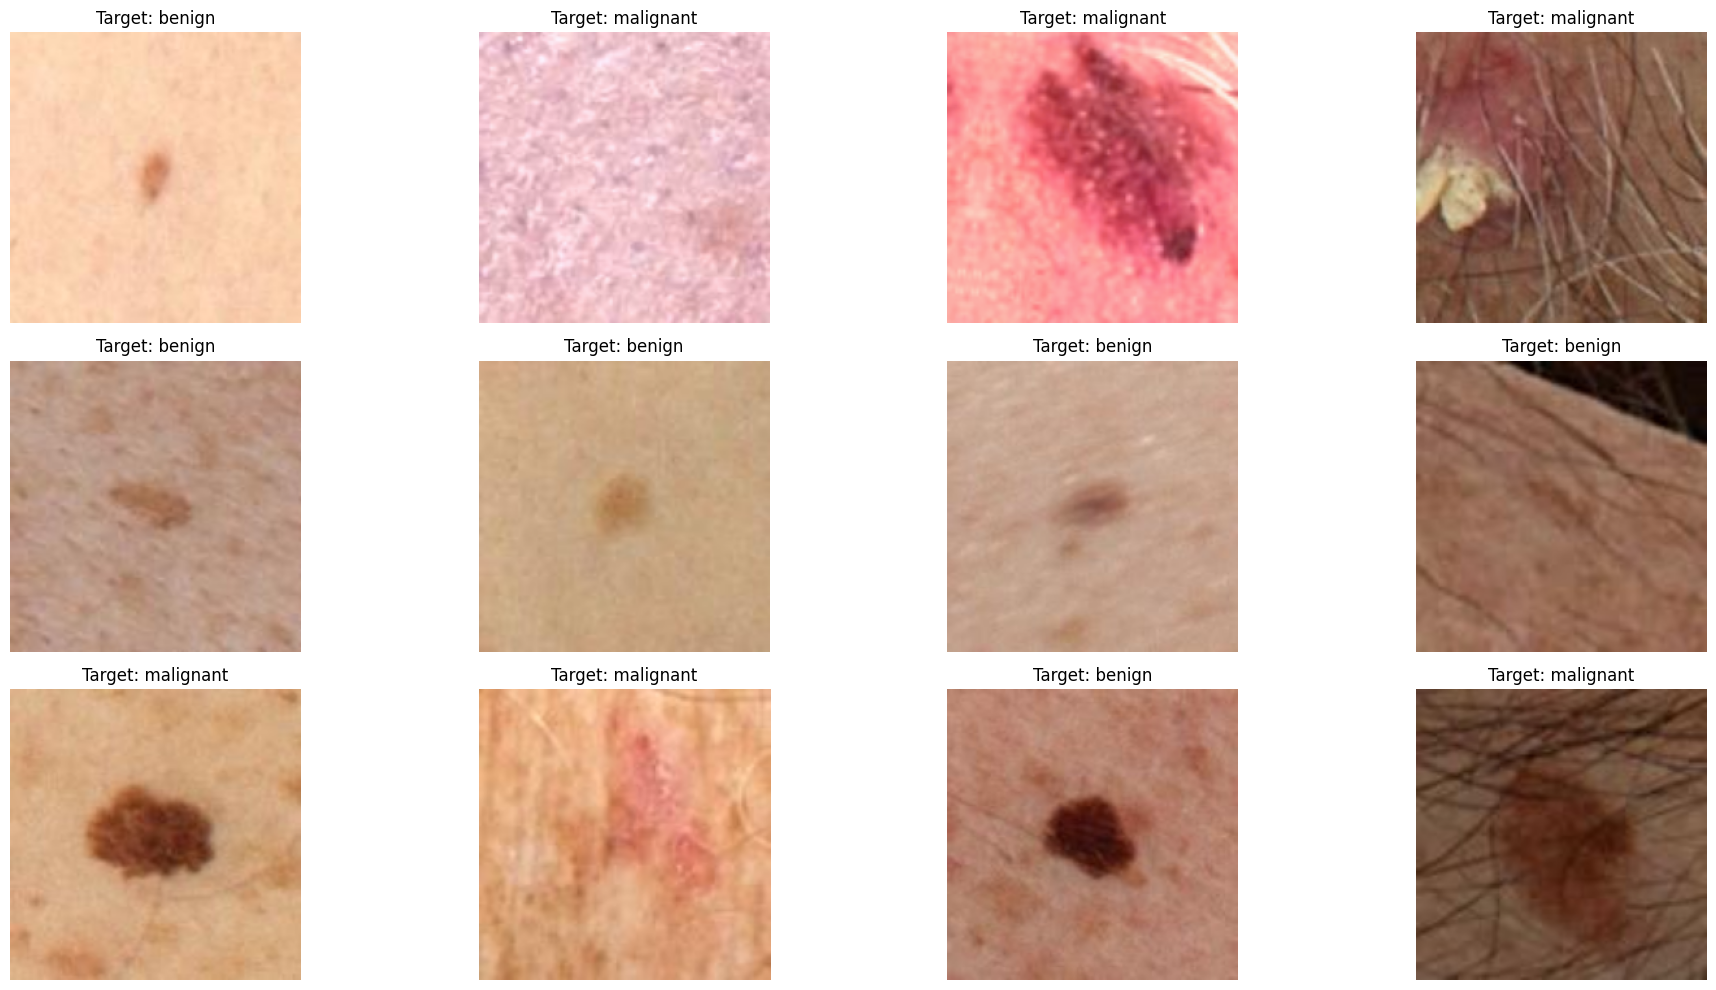

In [10]:
def visualize_sample_data(dataset, num_rows=3, num_cols=4):
    num_samples = num_rows * num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    
    # Flatten the axes array for easy indexing
    axes = axes.flatten()
    
    # Separate benign and malignant samples
    benign_samples = [i for i in range(len(dataset)) if dataset[i][2] == 0]
    malignant_samples = [i for i in range(len(dataset)) if dataset[i][2] == 1]
    
    # Determine number of samples to show from each class
    num_malignant_samples = num_samples // 2
    num_benign_samples = num_samples - num_malignant_samples
    
    # Randomly select samples from each class
    selected_malignant = rd.sample(malignant_samples, num_malignant_samples)
    selected_benign = rd.sample(benign_samples, num_benign_samples)
    selected_samples = selected_malignant + selected_benign
    
    # Shuffle selected samples to mix benign and malignant
    rd.shuffle(selected_samples)
    
    # Display the selected samples
    for i, sample_idx in enumerate(selected_samples):
        image, metadata, target = dataset[sample_idx]
        image = image.permute(1, 2, 0).cpu().numpy()  # Converting tensor to NumPy array
        axes[i].imshow(image)
        axes[i].set_title(f"Target: {'benign' if target == 0.0 else 'malignant'}")
        axes[i].axis('off')
    
    # Hide any remaining subplots if fewer samples than axes are available
    for j in range(len(selected_samples), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples from the training dataset
visualize_sample_data(train_dataset)

## Defining the Encoders

The model uses two encoders:

1. **SLE_FCN (Soft Label Encoder Fully Connected Network)**: Processes the metadata after soft label encoding. It outputs learned feature vectors from the metadata.

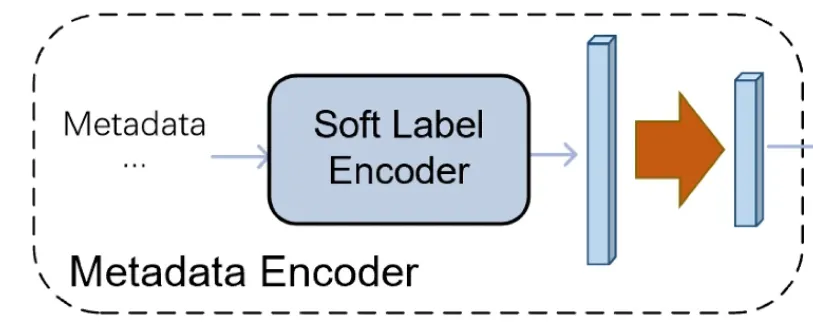

In [11]:
class SLE_FCN(nn.Module):
    def __init__(self, SLE_out_size = 40, num_classes = 100):
        super(SLE_FCN, self).__init__()
        self.linear = nn.Linear(SLE_out_size,num_classes)
        self.bn = nn.BatchNorm1d(num_classes)
        
    def forward(self, SLE_output):
        output = self.linear(SLE_output)
        output = self.bn(output)
        return output

2. **ViTEncoder (Vision Transformer Encoder)**: A Vision Transformer (ViT) pretrained on ImageNet is used to extract features from images. We unfreeze some of the final layers of the ViT model to fine-tune them on the ISIC skin lesion images.

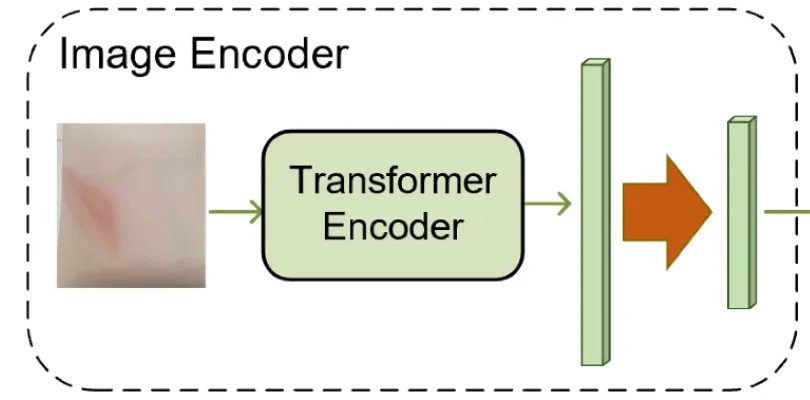

In [12]:
class ViTEncoder(nn.Module):
    def __init__(self, model_name, checkpoint_path, pretrained=False):
        super(ViTEncoder, self).__init__()
        self.model = timm.create_model(model_name, checkpoint_path =checkpoint_path, pretrained = pretrained)
        
        for param in self.model.parameters():
            param.requires_grad = False

        num_layers_to_unfreeze = 5
        
        params = list(self.model.parameters())[::-1]

        for param in params[:num_layers_to_unfreeze]:
            param.requires_grad = True
        
    def forward(self, images):
        output = self.model(images)
        return output

    
model = ViTEncoder('vit_base_patch16_224', checkpoint_path ='archive/jx_vit_base_p16_224-80ecf9dd.pth', pretrained=True)
model.to(device);

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

## Vision Transformer Fully Connected Network (ViT FCN)

After the Vision Transformer extracts features from the images, these features are passed through a simple fully connected network (FCN). This FCN refines the features before they are sent to the mutual attention block. The FCN applies a linear transformation followed by batch normalization.


In [13]:
class ViT_FCN(nn.Module):
    def __init__(self, ViT_out_size = 1000, num_classes = 100):
        super(ViT_FCN, self).__init__()
        self.linear = nn.Linear(ViT_out_size,num_classes)
        self.bn = nn.BatchNorm1d(num_classes)
        
    def forward(self, ViT_output):
        output = self.linear(ViT_output)
        output = self.bn(output)
        return output

## Mutual Attention Block

The core innovation of this model lies in the mutual attention mechanism. The mutual attention block combines features from both the image and metadata encoders. It does so by swapping the query vectors between image and metadata features, allowing each to attend to the other. This mechanism can be likened to two dermatologists—one who studied images and one who studied metadata—interacting to form a diagnosis.

This block uses multiple attention heads to learn different aspects of the data and integrates the features effectively using a skip connection.

The operation of the attention mechanism within each head can be described by the following formula:

$$
\text{head}_n = \text{Softmax} \left( \frac{q^n k^{nT}}{\sqrt{d}} \right) v^n
$$

Here, $q^n$ represents the query vector, $k^{nT}$ is the transposed key vector, $v^n$ is the value vector, and $d$ is the dimension of the query/key vectors, which is used for scaling.


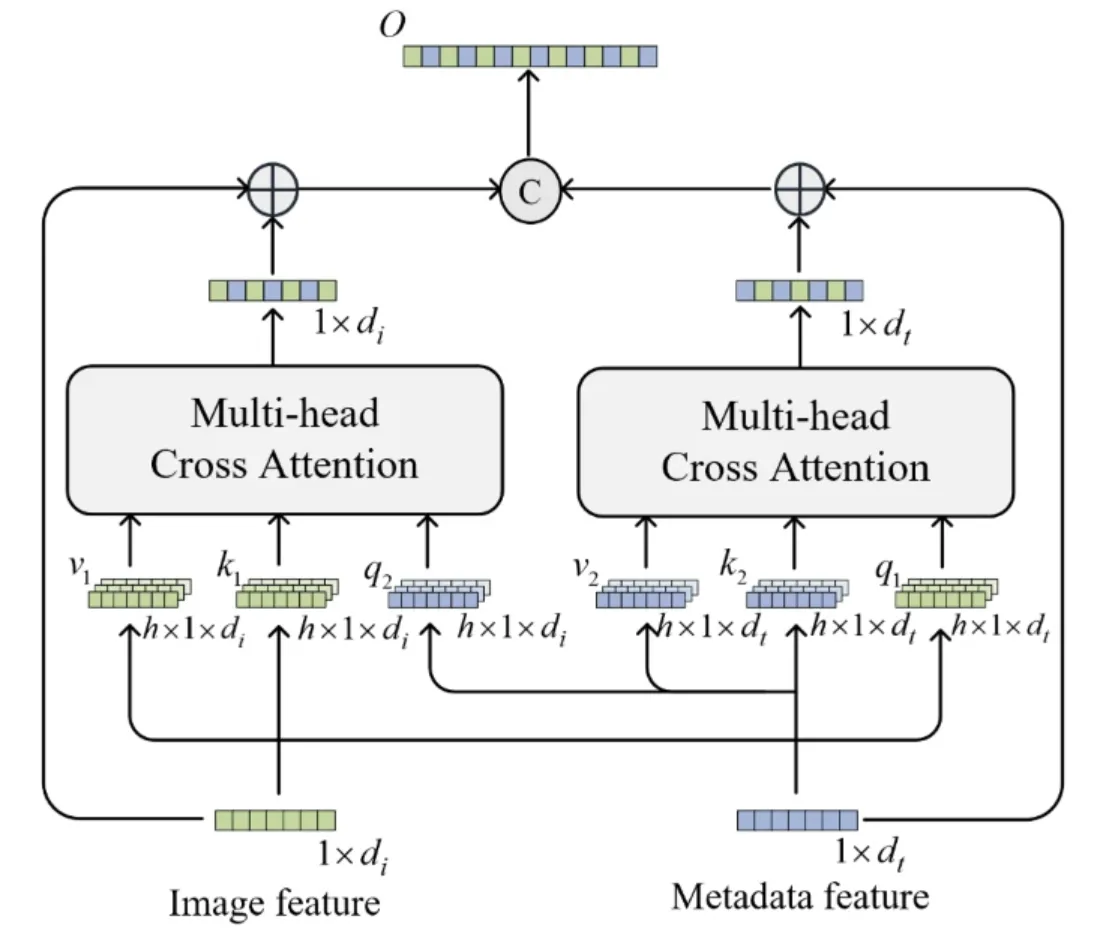

In [14]:
class MHA(nn.Module):
    def __init__(self, d_i, d_m, n_heads_i, n_heads_m):
        super(MHA, self).__init__()
        self.d_i = d_i
        self.d_m = d_m
        #trying out with different n_heads we'll see if this works
        self.n_heads_i = n_heads_i
        self.n_heads_m = n_heads_m
        
        #mappings for metadata
        #q_m needs to match k_i and vice-versa 
        self.q_mappings_m = nn.ModuleList([nn.Linear(d_m, d_i) for _ in range(self.n_heads_m)])
        self.k_mappings_m = nn.ModuleList([nn.Linear(d_m, d_m) for _ in range(self.n_heads_m)])
        self.v_mappings_m = nn.ModuleList([nn.Linear(d_m, d_m) for _ in range(self.n_heads_m)])
        #mappings for images
        self.q_mappings_i = nn.ModuleList([nn.Linear(d_i, d_m) for _ in range(self.n_heads_i)])
        self.k_mappings_i = nn.ModuleList([nn.Linear(d_i, d_i) for _ in range(self.n_heads_i)])
        self.v_mappings_i = nn.ModuleList([nn.Linear(d_i, d_i) for _ in range(self.n_heads_i)])
        self.softmax = nn.Softmax(dim=-1)
        self.linear_m = nn.Linear(self.n_heads_m * self.d_m, self.d_m)
        self.linear_i = nn.Linear(self.n_heads_i * self.d_i, self.d_i)

    def forward(self, image_input, metadata_input):
        result_i = []
        result_m = []
        
        for head in range(self.n_heads_i):
            q_mapping_m = self.q_mappings_m[head]
            k_mapping_i = self.k_mappings_i[head]
            v_mapping_i = self.v_mappings_i[head]
            
            k_i, v_i = k_mapping_i(image_input), v_mapping_i(image_input) 
            q_m = q_mapping_m(metadata_input)

            attention_i = self.softmax(q_m @ k_i.T / (self.d_i ** 0.5))
            result_i.append(attention_i @ v_i)
                
        for head in range(self.n_heads_m):
            q_mapping_i = self.q_mappings_i[head]
            k_mapping_m = self.k_mappings_m[head]
            v_mapping_m = self.v_mappings_m[head] 

            k_m, v_m = k_mapping_m(metadata_input), v_mapping_m(metadata_input)  
            q_i = q_mapping_i(image_input) 

            attention_m = self.softmax(q_i @ k_m.T / (self.d_m ** 0.5))
            result_m.append(attention_m @ v_m)
        
        # Concatenate results
        output_i = torch.cat(result_i, dim=-1)
        output_m = torch.cat(result_m, dim=-1)

        output_i = self.linear_i(output_i)
        output_m = self.linear_m(output_m)
        
        skip_step_i = output_i + image_input
        skip_step_m = output_m + metadata_input
        
        concat = torch.cat((skip_step_i, skip_step_m), dim=-1)

        return concat

## Final Fully Connected Network

The concatenated outputs from the mutual attention block are passed through a final fully connected network to produce the model's prediction. This network reduces the combined feature vector's dimensions and outputs the probability of the skin lesion being malignant using a sigmoid activation function.

In [15]:
class Final_FCN(nn.Module):
    def __init__(self, MHA_out_size = 200, num_classes = 1):
        super(Final_FCN, self).__init__()
        self.linear1 = nn.Linear(MHA_out_size,MHA_out_size//2)
        self.linear2 = nn.Linear(MHA_out_size//2, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, MHA_output):
        L1 = self.linear1(MHA_output)
        L2 = self.linear2(L1)
        output = self.sigmoid(L2)
        return output

In [16]:
class Multimodal_Transformer(nn.Module):
    def __init__(self, n_blocks, n_heads_i, n_heads_m):
        super(Multimodal_Transformer, self).__init__()
        self.n_blocks = n_blocks
        self.n_heads_i = n_heads_i
        self.n_heads_m = n_heads_m
        self.mha = MHA(d_i=100, d_m=100, n_heads_i=n_heads_i, n_heads_m=n_heads_m)
        
        self.sle_fcn = SLE_FCN()
        
        self.vit_encoder = ViTEncoder('vit_base_patch16_224', checkpoint_path = 'archive/jx_vit_base_p16_224-80ecf9dd.pth', pretrained=True).to(device)
        self.vit_fcn = ViT_FCN()
        
        self.final_fcn = Final_FCN()
        
        
    def forward(self, images, metadata):
        sle_fcn_output = self.sle_fcn(metadata)
        
        vit_encoded = self.vit_encoder(images)
        vit_fcn_output = self.vit_fcn(vit_encoded)
                        
        MHA_output = self.mha(sle_fcn_output, vit_fcn_output)
        
        predictions = self.final_fcn(MHA_output)
        
        return predictions

## Training Functions

To train the multimodal transformer, we define several helper functions:

- **train_one_epoch**: Executes one epoch of training and computes loss, accuracy, and recall.
- **validate_one_epoch**: Evaluates the model on the validation set.
- **preprocess_data**: Prepares the images, metadata, and targets for training.
- **compute_loss**: Computes the weighted loss to account for class imbalance.
- **collect_predictions**: Gathers predictions and targets for accuracy and recall computation.

These functions facilitate the training loop and provide metrics to monitor model performance.

In [17]:
def train_one_epoch(epoch, multimodal_transformer, train_loader, optimizer, criterion, device, num_steps, pos_weight=5):
    multimodal_transformer.train()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    for images, metadata, targets in pbar:
        images, metadata, targets = preprocess_data(images, metadata, targets, device)
        
        optimizer.zero_grad()
        outputs = multimodal_transformer(images, metadata)
        loss = compute_loss(outputs, targets, criterion, pos_weight)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        collect_predictions(all_predictions, all_targets, outputs, targets, device)
        
        current_accuracy = accuracy_score(all_targets, all_predictions)
        current_recall = recall_score(all_targets, all_predictions, zero_division=1)
        
        num_steps += 1
        pbar.set_postfix(loss=running_loss / num_steps, accuracy=current_accuracy, recall=current_recall)

    return running_loss, current_accuracy, current_recall

In [18]:
def validate_one_epoch(epoch, multimodal_transformer, val_loader, criterion, device, num_steps, pos_weight=5):
    multimodal_transformer.eval()
    val_loss = 0.0
    val_targets = []
    val_predictions = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'Epoch {epoch+1} Validation')
        for images, metadata, targets in pbar:
            images, metadata, targets = preprocess_data(images, metadata, targets, device)
            outputs = multimodal_transformer(images, metadata)
            loss = compute_loss(outputs, targets, criterion, pos_weight)
            
            val_loss += loss.item() * images.size(0)

            collect_predictions(val_predictions, val_targets, outputs, targets, device)

            current_val_accuracy = accuracy_score(val_targets, val_predictions)
            current_val_recall = recall_score(val_targets, val_predictions, zero_division=1)

            num_steps += 1
            pbar.set_postfix(loss=val_loss / num_steps, accuracy=current_val_accuracy, recall=current_val_recall)

    return val_loss, current_val_accuracy, current_val_recall

In [19]:
def preprocess_data(images, metadata, targets, device):
    images = images.to(device)
    metadata = metadata.to(device).float()
    targets = targets.to(device).float().view(-1, 1)
    return images, metadata, targets


In [20]:
def compute_loss(outputs, targets, criterion, pos_weight):
    weights = (targets * pos_weight) + (1 - targets)
    loss_no_weight = criterion(outputs, targets)
    loss = (weights * loss_no_weight).mean()
    return loss

In [21]:
def collect_predictions(predictions_list, targets_list, outputs, targets, device):
    predictions = (outputs > 0.5).float()
    if device == 'cuda':
        predictions_list.extend(predictions.cpu().detach().numpy())
        targets_list.extend(targets.cpu().detach().numpy())
    else:
        predictions_list.extend(predictions.detach().numpy())
        targets_list.extend(targets.detach().numpy())

In [22]:
def train_model(num_epochs, multimodal_transformer, train_loader, val_loader, optimizer, criterion, device):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_recall": [],
        "val_recall": []
    }
    for epoch in range(num_epochs):
        running_loss, train_accuracy, train_recall = train_one_epoch(
            epoch, multimodal_transformer, train_loader, optimizer, criterion, device, num_steps=0
        )
        val_loss, val_accuracy, val_recall = validate_one_epoch(
            epoch, multimodal_transformer, val_loader, criterion, device, num_steps=0
        )
        
        # Store the metrics in the history dictionary
        history["train_loss"].append(running_loss / len(train_loader.dataset))
        history["val_loss"].append(val_loss / len(val_loader.dataset))
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)
        history["train_recall"].append(train_recall)
        history["val_recall"].append(val_recall)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader.dataset):.2f}, '
              f'Val Loss: {val_loss / len(val_loader.dataset):.2f}, Val Accuracy: {val_accuracy:.2f}, '
              f'Val Recall: {val_recall:.2f}')
    return history

In [23]:
# Initialize the multimodal transformer
multimodal_transformer = Multimodal_Transformer(n_blocks = 12, n_heads_i = 12, n_heads_m = 12)
multimodal_transformer.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = Adam(multimodal_transformer.parameters(), lr=0.00001)

In [24]:
# Training loop
num_epochs = 20
history = train_model(num_epochs, multimodal_transformer, train_loader, val_loader, optimizer, criterion, device)

Epoch 1 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.36it/s, accuracy=0.97, loss=18.7, recall=0.127]  


Epoch 1/20, Train Loss: 0.66, Val Loss: 0.29, Val Accuracy: 0.97, Val Recall: 0.13


Epoch 2 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.972, loss=9.35, recall=0.165] 


Epoch 2/20, Train Loss: 0.24, Val Loss: 0.15, Val Accuracy: 0.97, Val Recall: 0.16


Epoch 3 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.965, loss=9.94, recall=0.278]


Epoch 3/20, Train Loss: 0.19, Val Loss: 0.16, Val Accuracy: 0.96, Val Recall: 0.28


Epoch 4 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.97, loss=8, recall=0.215]    


Epoch 4/20, Train Loss: 0.17, Val Loss: 0.13, Val Accuracy: 0.97, Val Recall: 0.22


Epoch 5 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.41it/s, accuracy=0.97, loss=8.03, recall=0.228]  


Epoch 5/20, Train Loss: 0.16, Val Loss: 0.13, Val Accuracy: 0.97, Val Recall: 0.23


Epoch 6 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.38it/s, accuracy=0.968, loss=7.59, recall=0.291]


Epoch 6/20, Train Loss: 0.15, Val Loss: 0.12, Val Accuracy: 0.97, Val Recall: 0.29


Epoch 7 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.41it/s, accuracy=0.971, loss=7.45, recall=0.278]


Epoch 7/20, Train Loss: 0.14, Val Loss: 0.12, Val Accuracy: 0.97, Val Recall: 0.28


Epoch 8 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.967, loss=7.52, recall=0.316]


Epoch 8/20, Train Loss: 0.13, Val Loss: 0.12, Val Accuracy: 0.97, Val Recall: 0.32


Epoch 9 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.968, loss=7.55, recall=0.342]


Epoch 9/20, Train Loss: 0.13, Val Loss: 0.12, Val Accuracy: 0.97, Val Recall: 0.34


Epoch 10 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.97, loss=7.18, recall=0.266] 


Epoch 10/20, Train Loss: 0.12, Val Loss: 0.11, Val Accuracy: 0.97, Val Recall: 0.27


Epoch 11 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.97, loss=7.07, recall=0.291] 


Epoch 11/20, Train Loss: 0.12, Val Loss: 0.11, Val Accuracy: 0.97, Val Recall: 0.29


Epoch 12 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.968, loss=7.34, recall=0.291]


Epoch 12/20, Train Loss: 0.11, Val Loss: 0.12, Val Accuracy: 0.97, Val Recall: 0.29


Epoch 13 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.965, loss=7.73, recall=0.291]


Epoch 13/20, Train Loss: 0.11, Val Loss: 0.12, Val Accuracy: 0.96, Val Recall: 0.29


Epoch 14 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.97, loss=7.17, recall=0.228] 


Epoch 14/20, Train Loss: 0.11, Val Loss: 0.11, Val Accuracy: 0.97, Val Recall: 0.23


Epoch 15 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.963, loss=8.09, recall=0.392]


Epoch 15/20, Train Loss: 0.11, Val Loss: 0.13, Val Accuracy: 0.96, Val Recall: 0.39


Epoch 16 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.39it/s, accuracy=0.971, loss=7.32, recall=0.304]


Epoch 16/20, Train Loss: 0.10, Val Loss: 0.11, Val Accuracy: 0.97, Val Recall: 0.30


Epoch 17 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.41it/s, accuracy=0.964, loss=7.94, recall=0.405]


Epoch 17/20, Train Loss: 0.10, Val Loss: 0.12, Val Accuracy: 0.96, Val Recall: 0.41


Epoch 19 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.41it/s, accuracy=0.969, loss=7.44, recall=0.291]


Epoch 19/20, Train Loss: 0.10, Val Loss: 0.12, Val Accuracy: 0.97, Val Recall: 0.29


Epoch 20 Validation: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, accuracy=0.965, loss=7.68, recall=0.367]

Epoch 20/20, Train Loss: 0.10, Val Loss: 0.12, Val Accuracy: 0.97, Val Recall: 0.37


## Visualizing Training Results

After training the model, we visualize the loss, accuracy, and recall curves to understand how well the model has learned the task. These plots help identify potential overfitting or underfitting issues. A well-trained model should show decreasing loss and increasing accuracy and recall on both training and validation datasets.

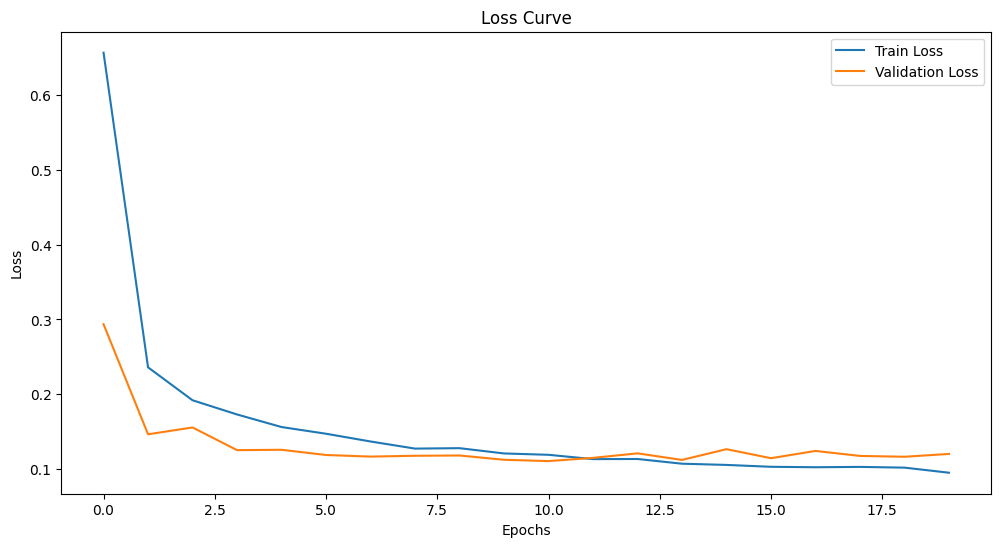

In [25]:
# Plotting the training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

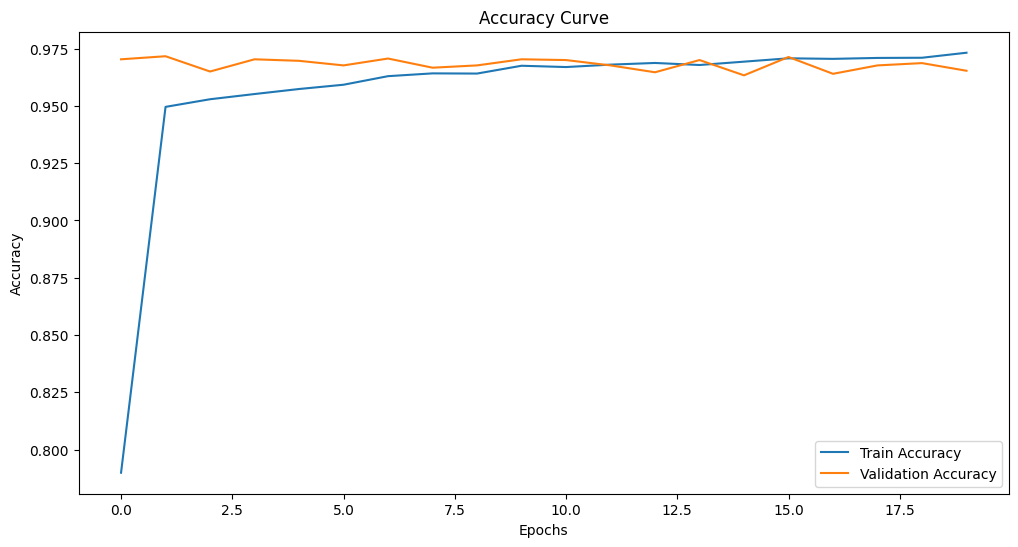

In [26]:
# Plotting the training and validation accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

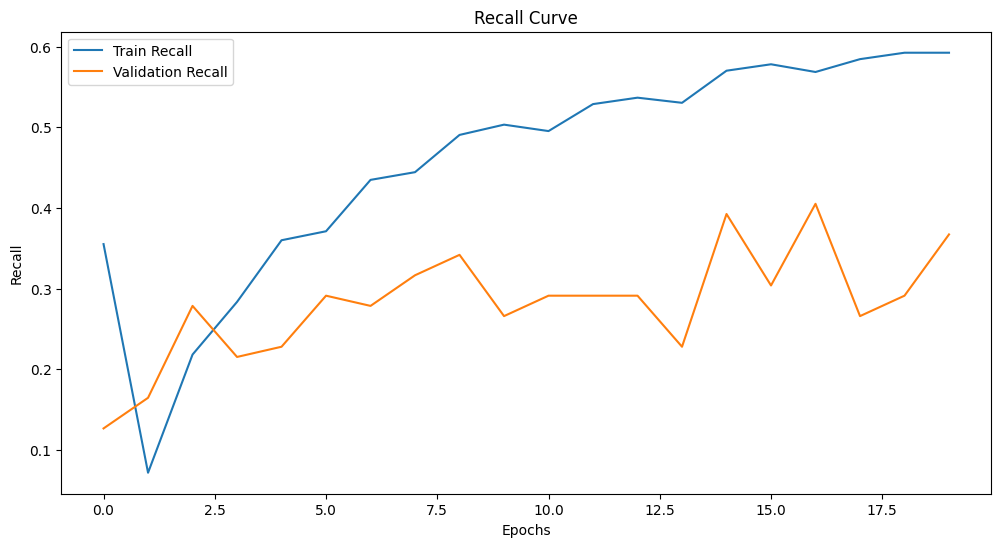

In [27]:
# Plotting the training and validation recall curves
plt.figure(figsize=(12, 6))
plt.plot(history['train_recall'], label='Train Recall')
plt.plot(history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

## Conclusion

In this notebook, we implemented a mutual attention model from scratch using PyTorch to classify skin lesions. By effectively combining image and metadata features, the model aims to leverage both visual and contextual information to improve classification accuracy. 

This template can be further optimized and adjusted to fit specific needs by tuning hyperparameters or modifying the architecture. We hope this implementation serves as a valuable resource for building robust multimodal models.